# Description of Data

Attribute Information:
1.date: Date in format dd/mm/yyyy

2.time: time in format hh:mm:ss

3.global_active_power: household global minute-averaged active power (in kilowatt)

4.global_reactive_power: household global minute-averaged reactive power (in kilowatt)

5.voltage: minute-averaged voltage (in volt)

6.global_intensity: household global minute-averaged current intensity (in ampere)

7.sub_metering_1: energy sub-metering No. 1 (in watt-hour of active energy). It corresponds to the kitchen, containing mainly a dishwasher, an oven and a microwave (hot plates are not electric but gas powered).

8.sub_metering_2: energy sub-metering No. 2 (in watt-hour of active energy). It corresponds to the laundry room, containing a washing-machine, a tumble-drier, a refrigerator and a light.

9.sub_metering_3: energy sub-metering No. 3 (in watt-hour of active energy). It corresponds to an electric water-heater and an air-conditioner.

# Load Packages

In [ ]:
# Let`s import all packages that we may need:

import sys 
import numpy as np # linear algebra
from scipy.stats import randint
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.model_selection import KFold # use for cross validation
from sklearn.preprocessing import StandardScaler # for normalization
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline # pipeline making
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel
from sklearn import metrics # for the check the error and accuracy of the model
from sklearn.metrics import mean_squared_error,r2_score
import statsmodels.tsa.api as smt
import statsmodels.api as sm

from itertools import product                    # some useful functions
#from tqdm import tqdm_notebook
from tqdm import tqdm

## for Deep-learing:
from tensorflow import keras
import tensorflow as tf
from keras.layers import Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from keras.optimizers import SGD 
from keras.callbacks import EarlyStopping
from keras.utils import np_utils
import itertools
from keras.layers import LSTM
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers import Dropout, Flatten, TimeDistributed

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Data/household_power_consumption.txt',
                 sep = ';', parse_dates = {'dt' : ['Date', 'Time']}, infer_datetime_format = True,
                 low_memory = False, na_values = ['nan','?'], index_col = 'dt')

In [ ]:
df.head() 

,Global_active_power,Global_reactive_power,Voltage,Global_intensity,Sub_metering_1,Sub_metering_2,Sub_metering_3
dt,,,,,,,
2006-12-16 17:24:00,4.216,0.418,234.84,18.4,0.0,1.0,17.0
2006-12-16 17:25:00,5.360,0.436,233.63,23.0,0.0,1.0,16.0
2006-12-16 17:26:00,5.374,0.498,233.29,23.0,0.0,2.0,17.0
2006-12-16 17:27:00,5.388,0.502,233.74,23.0,0.0,1.0,17.0
2006-12-16 17:28:00,3.666,0.528,235.68,15.8,0.0,1.0,17.0


In [ ]:
tf.random.set_seed(1234)

#Deep-Leaning: LSTM Data Preparation and feature engineering

* Missing value treatment

* As readings are for each minute, we can replcae the missing values with reading obtained 24 hours ago
* This is a very simple approach.Better way would be to calculate the average 
* usage of a particular time for a window duration and then use that value to replace the missing values

* Fill the missing values with reading obtained 24 hours ago
* 1 hour has 60 observations


In [ ]:
# Check for na values
df.isna().sum()
# Readings for 25979 observations missing

# Check the proportion of missing values

df.isna().sum()/df.shape[0]

Global_active_power      0.012518
Global_reactive_power    0.012518
Voltage                  0.012518
Global_intensity         0.012518
Sub_metering_1           0.012518
Sub_metering_2           0.012518
Sub_metering_3           0.012518
dtype: float64

In [ ]:
def fill_missing(dat):
    window = 60 * 24
    for row in range(dat.shape[0]):
        for col in range(dat.shape[1]):
            if np.isnan(dat[row,col]):
                dat[row, col] = dat[row - window, col]

In [ ]:
fill_missing(df.values)
df.isna().sum()
#df.head()
#df.info()

Global_active_power      0
Global_reactive_power    0
Voltage                  0
Global_intensity         0
Sub_metering_1           0
Sub_metering_2           0
Sub_metering_3           0
dtype: int64

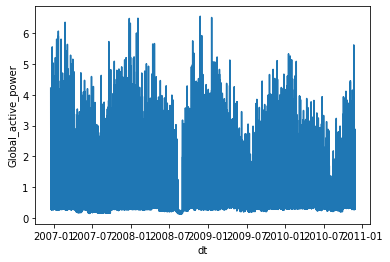

In [ ]:
# As our focus is on getting a read on daily consumption it is a good idea
# to downsample the data to daily readings

df_resampled_hourly_avg = df.resample('H').mean()
df_resampled_hourly_avg.head()
df_resampled_hourly_avg.shape
# 34589,7
sns.lineplot(data=df_resampled_hourly_avg, y='Global_active_power',
             x=df_resampled_hourly_avg.index)

df_resample = df_resampled_hourly_avg.resample('D').mean()

* Data resampled at day level just for comparison


In [ ]:
## resampling of data over hour
#df_resample = df.resample('D').mean() 
print(df_resample) 
df_resample.shape

            Global_active_power  ...  Sub_metering_3
dt                               ...                
2006-12-16             3.120298  ...       12.692063
2006-12-17             2.354486  ...        9.264583
2006-12-18             1.530435  ...        9.734722
2006-12-19             1.157079  ...        4.303472
2006-12-20             1.545658  ...        9.765972
...                         ...  ...             ...
2010-11-22             1.417733  ...        7.038889
2010-11-23             1.095511  ...        5.285417
2010-11-24             1.247394  ...        8.488889
2010-11-25             0.993864  ...        3.522222
2010-11-26             1.167712  ...        7.567424

[1442 rows x 7 columns]


(1442, 7)

In [ ]:
import calendar
calendar.day_name[df_resample.index.weekday[0]]

'Saturday'

* Starting day in data is a **Saturday**
* We will remove first 2 observations so that data starts from Monday, so that it is easy to visualize a weekly seasonality if it exists

In [ ]:
df_resample_sliced = df_resample[2:]
df_resample_sliced.shape
calendar.day_name[df_resample_sliced.index.weekday[0]]

'Monday'

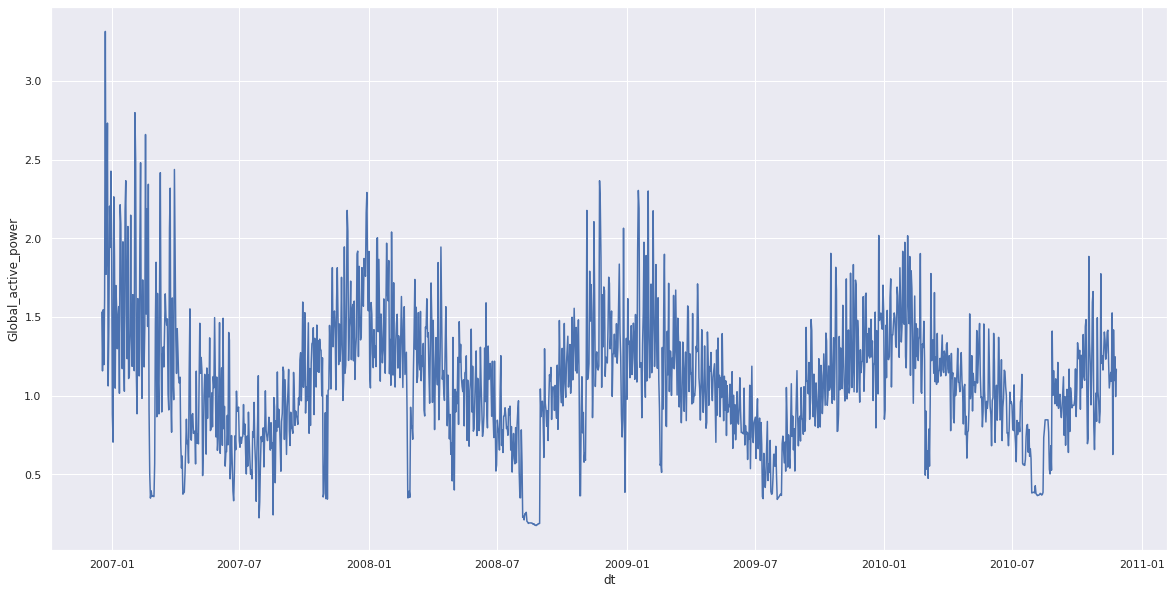

In [ ]:
sns.set_theme()
fig, ax = plt.subplots(figsize = (20,10))
sns.lineplot(data = df_resample_sliced, y = 'Global_active_power', x = df_resample_sliced.index)

**Active power usage by Month**

In [ ]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%b'), sort = False)['Global_active_power'].mean()

dt
Dec    1.477656
Jan    1.460179
Feb    1.300928
Mar    1.230836
Apr    1.039632
May    1.029559
Jun    0.906512
Jul    0.700587
Aug    0.583312
Sep    0.974386
Oct    1.137197
Nov    1.291483
Name: Global_active_power, dtype: float64

* We can clearly see that there is a monthly seasonality present in power consumed by appliances(Global active power
* Usage drops around middle of the year and peaking towards the end of year

**Active power usage by Weekday**

In [ ]:
df_resample_sliced.groupby(df_resample_sliced.index.strftime('%a'), sort = False)['Global_active_power'].mean()

dt
Mon    0.997309
Tue    1.069351
Wed    1.082994
Thu    0.980880
Fri    1.042470
Sat    1.238724
Sun    1.206729
Name: Global_active_power, dtype: float64

* Usage peaks around weekend and weekday usage more or less remains similar which is what we are expecting 

In [ ]:

df_resample_day = df_resample_sliced


df_resample_day.head()

# Min and Max dates
df_resample_day.index.min()
# 2006-12-18
df_resample_day.index.max()
# 2010-11-26

df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]

df_resample_day_y.head()
print(type(df_resample_day_y))

<class 'pandas.core.frame.DataFrame'>


**Transform the data into a time series problem**

In [ ]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg
 

In [ ]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day.values 


## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

# drop columns we don't want to predict
reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  ...  var6(t-1)  var7(t-1)   var1(t)
1   0.431901   0.234750   0.620518  ...   0.216451   0.566912  0.313037
2   0.313037   0.202322   0.667476  ...   0.627798   0.218615  0.436748
3   0.436748   0.232377   0.686364  ...   0.218680   0.568916  0.325660
4   0.325660   0.182871   0.608740  ...   0.222314   0.408283  0.462304
5   0.462304   0.309810   0.617634  ...   0.028904   0.438343  1.000000

[5 rows x 8 columns]


In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.38

# Model - 1(LSTM)

**Splitting the data to train and validation sets**

We will be using almost last 6 months of our data as validation data to check how our deep learning network is performing

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 1, 7) (1200,) (233, 1, 7) (233,)


In [ ]:
mape_lst = list()

Epoch 1/20
18/18 - 3s - loss: 0.1506 - val_loss: 0.0728
Epoch 2/20
18/18 - 0s - loss: 0.0548 - val_loss: 0.0202
Epoch 3/20
18/18 - 0s - loss: 0.0421 - val_loss: 0.0197
Epoch 4/20
18/18 - 0s - loss: 0.0410 - val_loss: 0.0197
Epoch 5/20
18/18 - 0s - loss: 0.0411 - val_loss: 0.0197
Epoch 6/20
18/18 - 0s - loss: 0.0405 - val_loss: 0.0195
Epoch 7/20
18/18 - 0s - loss: 0.0404 - val_loss: 0.0194
Epoch 8/20
18/18 - 0s - loss: 0.0403 - val_loss: 0.0194
Epoch 9/20
18/18 - 0s - loss: 0.0394 - val_loss: 0.0193
Epoch 10/20
18/18 - 0s - loss: 0.0398 - val_loss: 0.0193
Epoch 11/20
18/18 - 0s - loss: 0.0391 - val_loss: 0.0193
Epoch 12/20
18/18 - 0s - loss: 0.0390 - val_loss: 0.0194
Epoch 13/20
18/18 - 0s - loss: 0.0389 - val_loss: 0.0194
Epoch 14/20
18/18 - 0s - loss: 0.0383 - val_loss: 0.0194
Epoch 15/20
18/18 - 0s - loss: 0.0389 - val_loss: 0.0194
Epoch 16/20
18/18 - 0s - loss: 0.0375 - val_loss: 0.0194
Epoch 17/20
18/18 - 0s - loss: 0.0372 - val_loss: 0.0194
Epoch 18/20
18/18 - 0s - loss: 0.0375 - 

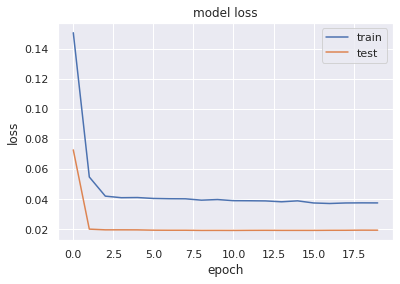

Test RMSE: 0.219
MAPE: 18.637


In [ ]:

model = Sequential()
model.add(LSTM(100, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=20, batch_size=70, validation_data=(test_X, test_y), verbose=2, shuffle=False)

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse)
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)

In [ ]:
len(inv_yhat_lstm)

233

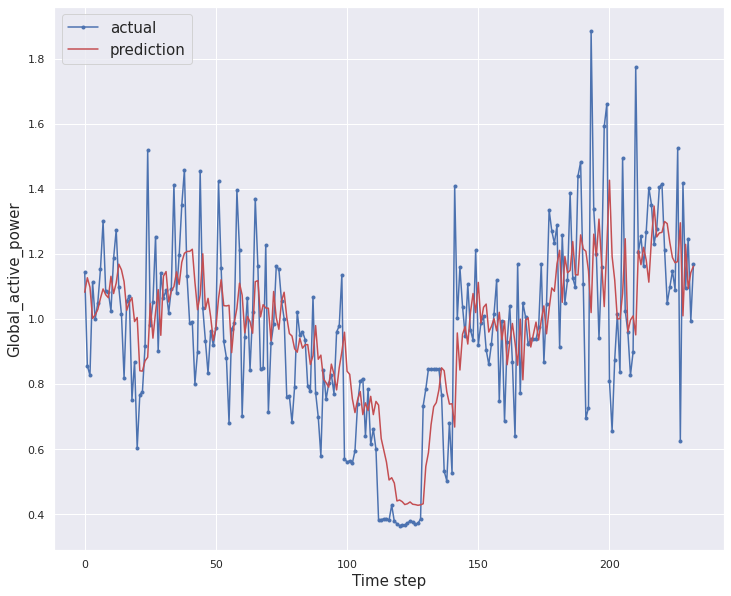

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len(test_X))]
plt.plot(aa, inv_y[:len(test_X)], marker='.', label="actual")
plt.plot(aa, inv_yhat_lstm[:len(test_X)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Identify the suitable window for lags

In [ ]:
## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]


In [ ]:
lags = 31
model_details = {}
def build_lstm_model():
    model = Sequential()
    model.add(LSTM(units = 128, input_shape = (train_X.shape[1], train_X.shape[2])))
    model.add(Dense(units = 1))
    model.compile(loss = 'mean_absolute_error', optimizer = 'adam')
    return model

def run_model(model, train_data, validation_data):
    model_det_dict = {}
    n_features = train_data[0].shape[2]
    history = model.fit(train_data[0], train_data[1],  epochs=20, 
                        validation_data=(validation_data[0],validation_data[1]),
                        verbose=2, shuffle=False)
    # We reshaped the input into the 3D format as expected by LSTMs, 
    # make a prediction
    yhat = model.predict(test_X)
    x_test = validation_data[0].reshape((validation_data[0].shape[0], n_features))
    #print(x_test)
    # invert scaling for forecast
    inv_yhat = np.concatenate((yhat, x_test), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,0]
    # invert scaling for actual
    y_test = validation_data[1].reshape((len(validation_data[1]), 1))
    inv_y = np.concatenate((y_test, x_test), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,0]
    rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat))
    print('Test RMSE: %.3f' % rmse)
    loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat)
    print('MAPE: %.3f' % loss)
    model_det_dict = {'n_features': n_features,
                      'Val_RMSE':rmse,
                      'Val_MAPE':loss.numpy(),
                      'actual': inv_y,
                      'predicted': inv_yhat}
    print(model_det_dict)
    return model_det_dict
    

for lag in range(1, lags + 1):
    reframed = series_to_supervised(scaled, lag, 1)
    print(reframed.shape)
    # split into train and test sets
    values = reframed.values
    n_train_time = 1200
    train = values[:n_train_time, :]
    test = values[n_train_time:, :]
    train.shape, test.shape
    ##test = values[n_train_time:n_test_time, :]
    # split into input and outputs
    train_X, train_y = train[:, :-1], train[:, -1]
    test_X, test_y = test[:, :-1], test[:, -1]
    # reshape input to be 3D [samples, timesteps, features]
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    n_features = train_X.shape[2]
    model = build_lstm_model()
    model_details['Model_'+str(lag)] = run_model(model, train_data=(train_X, train_y),
                                validation_data=(test_X, test_y))
    
    #print(model_details)
    
for model_id, model_data in model_details.items():
    print("Model_ID:", model_id)
    print(f"ValidationData-RMSE: {model_data['Val_RMSE']:.3f}")
    print(f"ValidationData-MAPE: {model_data['Val_MAPE']:.3f}")
    print(10*"#")
        
    


(1439, 2)
(1200, 1, 1) (1200,) (239, 1, 1) (239,)
Epoch 1/20
38/38 - 2s - loss: 0.3468 - val_loss: 0.2539
Epoch 2/20
38/38 - 0s - loss: 0.2000 - val_loss: 0.1196
Epoch 3/20
38/38 - 0s - loss: 0.1790 - val_loss: 0.1176
Epoch 4/20
38/38 - 0s - loss: 0.1755 - val_loss: 0.1152
Epoch 5/20
38/38 - 0s - loss: 0.1727 - val_loss: 0.1135
Epoch 6/20
38/38 - 0s - loss: 0.1707 - val_loss: 0.1119
Epoch 7/20
38/38 - 0s - loss: 0.1691 - val_loss: 0.1114
Epoch 8/20
38/38 - 0s - loss: 0.1682 - val_loss: 0.1105
Epoch 9/20
38/38 - 0s - loss: 0.1674 - val_loss: 0.1101
Epoch 10/20
38/38 - 0s - loss: 0.1669 - val_loss: 0.1099
Epoch 11/20
38/38 - 0s - loss: 0.1665 - val_loss: 0.1097
Epoch 12/20
38/38 - 0s - loss: 0.1663 - val_loss: 0.1095
Epoch 13/20
38/38 - 0s - loss: 0.1660 - val_loss: 0.1095
Epoch 14/20
38/38 - 0s - loss: 0.1659 - val_loss: 0.1093
Epoch 15/20
38/38 - 0s - loss: 0.1657 - val_loss: 0.1092
Epoch 16/20
38/38 - 0s - loss: 0.1656 - val_loss: 0.1091
Epoch 17/20
38/38 - 0s - loss: 0.1656 - val_los

* We ran a LSTM architecture with different sets of lags from 1 to 31
* This is done to identify which lag will give a better result
* From the output we can see that a window size of 7 days works best. 
* Any information more than 2 weeks cause a drop in model performance

# Model - 2(CNN)

**CNN for Time Series Forecasting**

* For the CNN model we will use one convolutional hidden layer followed by a max pooling layer. The filter maps are then flattened before being interpreted by a Dense layer and outputting a prediction.
* The convolutional layer should be able to identify patterns between the timesteps.
* Input shape **[samples, timesteps, features]**.

**Data preprocess**
* Reshape from [samples, timesteps] into [samples, timesteps, features].
* This same reshaped data will be used on the CNN and the LSTM model.

In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.38

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(50, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam())
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20, verbose=2)
model_cnn.summary()

Epoch 1/20
38/38 - 1s - loss: 0.0781 - val_loss: 0.0241
Epoch 2/20
38/38 - 0s - loss: 0.0418 - val_loss: 0.0206
Epoch 3/20
38/38 - 0s - loss: 0.0401 - val_loss: 0.0205
Epoch 4/20
38/38 - 0s - loss: 0.0391 - val_loss: 0.0216
Epoch 5/20
38/38 - 0s - loss: 0.0387 - val_loss: 0.0202
Epoch 6/20
38/38 - 0s - loss: 0.0376 - val_loss: 0.0205
Epoch 7/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0208
Epoch 8/20
38/38 - 0s - loss: 0.0373 - val_loss: 0.0203
Epoch 9/20
38/38 - 0s - loss: 0.0365 - val_loss: 0.0204
Epoch 10/20
38/38 - 0s - loss: 0.0366 - val_loss: 0.0204
Epoch 11/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0203
Epoch 12/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0217
Epoch 13/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0206
Epoch 14/20
38/38 - 0s - loss: 0.0359 - val_loss: 0.0203
Epoch 15/20
38/38 - 0s - loss: 0.0354 - val_loss: 0.0203
Epoch 16/20
38/38 - 0s - loss: 0.0351 - val_loss: 0.0209
Epoch 17/20
38/38 - 0s - loss: 0.0345 - val_loss: 0.0203
Epoch 18/20
38/38 - 0s - loss: 0.0353 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn.predict(X_train_series)
yhat = model_cnn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_cnn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn = scaler.inverse_transform(inv_yhat_cnn)
inv_yhat_cnn = inv_yhat_cnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



Train rmse: 0.18277140307840292
Validation rmse: 0.2211415362727364
MAPE: 18.864


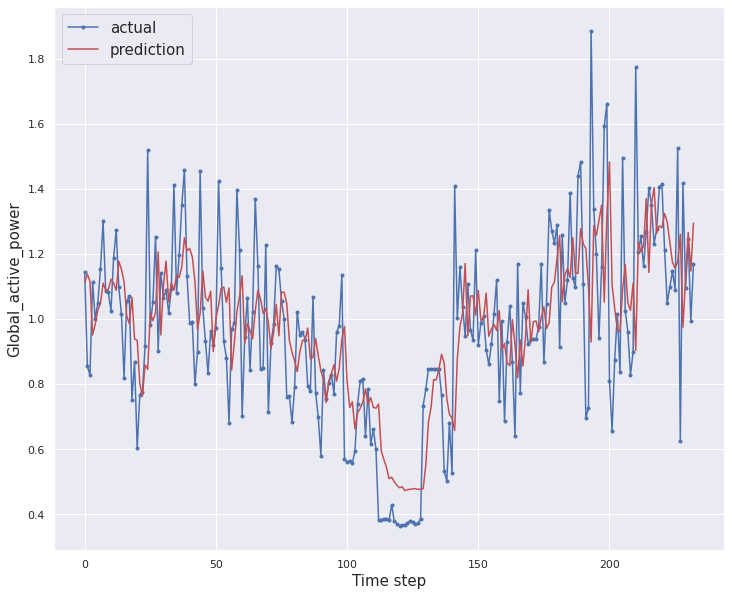

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, Dense, Flatten, MaxPooling1D

In [ ]:
# model_cnn = Sequential()
# model_cnn.add(Conv1D(filters=128, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
# model_cnn.add(MaxPooling1D(pool_size=2))
# model_cnn.add(Flatten())
# model_cnn.add(Dense(50, activation='relu'))
# model_cnn.add(Dense(1))
# model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam())
# #model_cnn.summary()
inputs = Input(shape=(7,1))
x = Conv1D(filters=128, kernel_size=2, activation='relu')(inputs)
x = MaxPooling1D(pool_size=2)(x)
x = Flatten()(x)
x = Dense(units=50, activation='relu')(x)
output = Dense(units=1)(x)

model = Model(inputs, output, name='Vanilla_CNN')
model.compile(optimizer='adam', loss='mean_absolute_error')

model.summary()

Model: "Vanilla_CNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 7, 1)]            0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 6, 128)            384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 3, 128)            0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 50)                19250     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 51        
Total params: 19,685
Trainable params: 19,685
Non-trainable params: 0
___________________________________________________

# Model -3(CNN + LSTM)

**CNN-LSTM for Time Series Forecasting**
* Input shape **[samples, subsequences, timesteps, features]**.

 Model explanation from the [article](https://machinelearningmastery.com/how-to-get-started-with-deep-learning-for-time-series-forecasting-7-day-mini-course/)
> "The benefit of this model is that the model can support very long input sequences that can be read as blocks or subsequences by the CNN model, then pieced together by the LSTM model."
>
> "When using a hybrid CNN-LSTM model, we will further divide each sample into further subsequences. The CNN model will interpret each sub-sequence and the LSTM will piece together the interpretations from the subsequences. As such, we will split each sample into 2 subsequences of 2 times per subsequence."
>
> "The CNN will be defined to expect 2 timesteps per subsequence with one feature. The entire CNN model is then wrapped in TimeDistributed wrapper layers so that it can be applied to each subsequence in the sample. The results are then interpreted by the LSTM layer before the model outputs a prediction."

 **Data preprocess**
* Reshape from [samples, timesteps, features] into [samples, subsequences, timesteps, features].

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1200, 1, 7, 1)
Validation set shape (233, 1, 7, 1)


In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=128, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(100, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam())
model.summary()

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_85 (ModuleWra (None, 128)               81920     
_________________________________________________________________
module_wrapper_86 (ModuleWra (None, 1)                 129       
Total params: 82,049
Trainable params: 82,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 2s - loss: 0.0771 - val_loss: 0.0268
Epoch 2/20
38/38 - 0s - loss: 0.0427 - val_loss: 0.0208
Epoch 3/20
38/38 - 0s - loss: 0.0415 - val_loss: 0.0207
Epoch 4/20
38/38 - 0s - loss: 0.0396 - val_loss: 0.0215
Epoch 5/20
38/38 - 0s - loss: 0.0388 - val_loss: 0.0221
Epoch 6/20
38/38 - 0s - loss: 0.0387 - val_loss: 0.0208
Epoch 7/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0217
Epoch 8/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0209
Epoch 9/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0205
Epoch 10/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0225
Epoch 11/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0217
Epoch 12/20
38/38 - 0s - loss: 0.0362 - val_loss: 0.0203
Epoch 13/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0235
Epoch 14/20
38/38 - 0s - loss: 0.0363 - val_loss: 0.0198
Epoch 15/20
38/38 - 0s - loss: 0.0354 - val_loss: 0.0213
Epoch 16/20
38/38 - 0s - loss: 0.0352 - val_loss: 0.0216
Epoch 17/20
38/38 - 0s - loss: 0.0353 - val_loss: 0.0221
Epoch 18/20
38/38 - 0s - loss: 0.0356 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn_lstm.predict(X_train_series_sub)

yhat = model_cnn_lstm.predict(X_valid_series_sub)
# invert scaling for forecast
inv_yhat_cnn_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn_lstm = scaler.inverse_transform(inv_yhat_cnn_lstm)
inv_yhat_cnn_lstm = inv_yhat_cnn_lstm[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn_lstm)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




Train rmse: 0.18204525077996642
Validation rmse: 0.22264090642167061
MAPE: 19.065


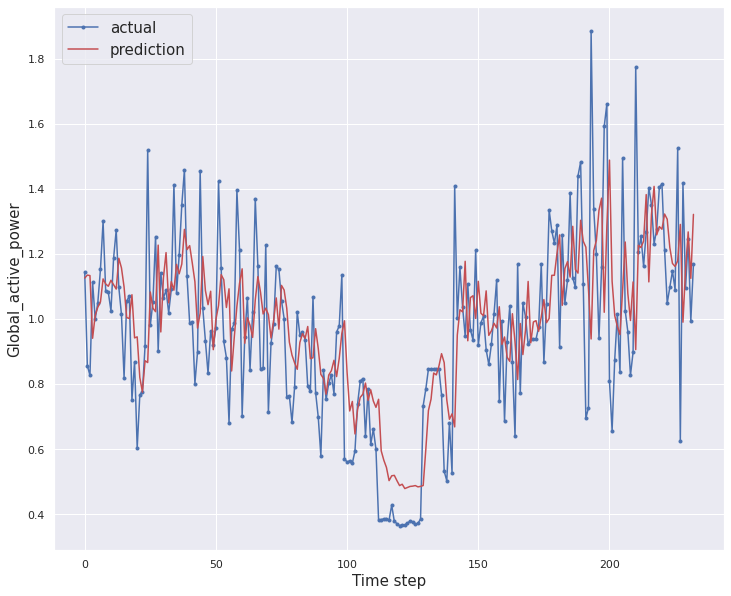

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn_lstm[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

# Model -4(TCN)

**Temporal CNN**

In [ ]:
pip install keras-tcn

     |████████████████████████████████| 686kB 2.9MB/s 


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
from tcn import TCN, tcn_full_summary, compiled_tcn, tcn
from tensorflow.keras.models import Sequential

In [ ]:
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

tcn_layer = TCN(input_shape=(7, 1),
                nb_filters = 128,
                dilations = (1,2,4,8),
                activation = 'relu',
                use_skip_connections = True)

# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

model_tcn = Sequential([
    tcn_layer,
    Dense(1)
])

model_tcn.compile(optimizer='adam', loss='mse')
model_tcn.summary()
#tcn_full_summary(m, expand_residual_blocks=False)

model_tcn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20)

Receptive field size = 61
Model: "sequential_45"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn (TCN)                    (None, 128)               345728    
_________________________________________________________________
module_wrapper_97 (ModuleWra (None, 1)                 129       
Total params: 345,857
Trainable params: 345,857
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
38/38 [==============================] - 5s 86ms/step - loss: 0.6942 - val_loss: 0.0205
Epoch 2/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0451 - val_loss: 0.0260
Epoch 3/20
38/38 [==============================] - 1s 34ms/step - loss: 0.0371 - val_loss: 0.0202
Epoch 4/20
38/38 [==============================] - 1s 36ms/step - loss: 0.0380 - val_loss: 0.0211
Epoch 5/20
38/38 [==============================] - 1s 33ms/step - loss: 0.0357 - val_l

In [ ]:

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

tcn_train_pred = model_tcn.predict(X_train_series)

yhat = model_tcn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_tcn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_tcn = scaler.inverse_transform(inv_yhat_tcn)
inv_yhat_tcn = inv_yhat_tcn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, tcn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_tcn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_tcn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)


Train rmse: 0.16113453996914098
Validation rmse: 0.2326654289388346
MAPE: 21.396


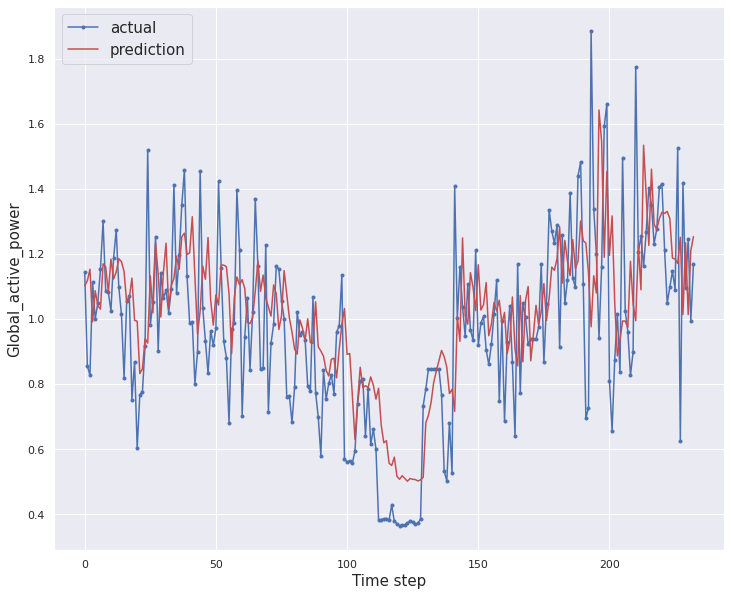

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_tcn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

In [ ]:
mape_lst[0].eval

<bound method _EagerTensorBase.eval of <tf.Tensor: shape=(), dtype=float64, numpy=27.12617896616368>>

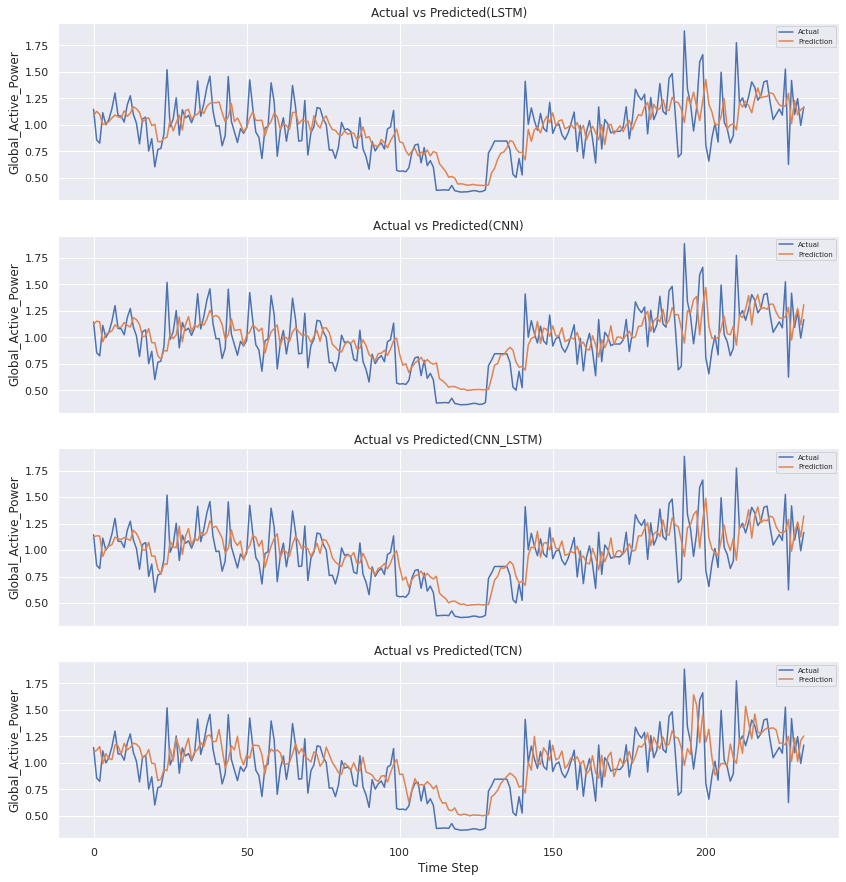

In [ ]:
data = {"Actual" : inv_y, "LSTM": inv_yhat_lstm, "CNN":inv_yhat_cnn,
              "CNN_LSTM": inv_yhat_cnn_lstm, "TCN":inv_yhat_tcn}
a_vs_p = pd.DataFrame(data)
a_vs_p

fig, axs=  plt.subplots(4, sharex= True, figsize = (14,15))
aa = [x for x in range(a_vs_p.shape[0])]
for i in range(4):
  axs[i].plot(aa, a_vs_p.iloc[:,0], label = 'Actual')
  axs[i].plot(aa, a_vs_p.iloc[:, i +1], label = 'Prediction')
  axs[i].set_title("Actual vs Predicted(" + list(data.keys())[i+1]+")")
  axs[i].legend(fontsize = 7)

for ax in axs.flat:
  ax.set(xlabel='Time Step', ylabel='Global_Active_Power')

for ax in axs.flat:
  ax.label_outer()

'Predicted_LSTM'

# Model-5(MACNN)

In [ ]:
#df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 28, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-28)  var1(t-27)  var1(t-26)  ...  var1(t-2)  var1(t-1)   var1(t)
28     -0.136197   -0.373925   -0.126504  ...   0.298456   0.220027 -0.160582
29     -0.373925   -0.126504   -0.348679  ...   0.220027  -0.160582 -0.364989
30     -0.126504   -0.348679   -0.075393  ...  -0.160582  -0.364989  0.148503
31     -0.348679   -0.075393    1.000000  ...  -0.364989   0.148503 -0.305269
32     -0.075393    1.000000    0.016878  ...   0.148503  -0.305269 -0.456061
...          ...         ...         ...  ...        ...        ...       ...
1435   -0.596296   -0.692420   -0.553411  ...  -0.139213  -0.712315 -0.207958
1436   -0.692420   -0.553411   -0.463628  ...  -0.712315  -0.207958 -0.413127
1437   -0.553411   -0.463628   -0.578109  ...  -0.207958  -

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 28) (1200,) (212, 28) (212,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 28, 1)
Validation set shape (212, 28, 1)


In [ ]:
from keras import Input, Model
from keras.layers import Conv1D, BatchNormalization, GlobalAveragePooling1D,  Dense, concatenate, Multiply
from keras.activations import ReLU


In [ ]:
from keras.activations import relu

## Iteration-1

In [ ]:
inputs = Input(shape=(28,1), name='series')
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
conv1 = concatenate([conv1_a, conv1_b, conv1_c])

conv1 = BatchNormalization()(conv1)
msblock = ReLU()(conv1)
out = GlobalAveragePooling1D()(msblock)

# Flatten the ouput
#out = Flatten()(out)
out = Dense(units=64)(out)
out = Dense(units=192)(out)
out = ReLU()(out)

attblock = Multiply()([out, msblock])
attblock = Flatten()(attblock)
attblock = Dense(units=1)(attblock)

model = Model(inputs, attblock, name='MACNN')
model.compile(optimizer='Adam', loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_20 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_21 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_22 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,shuffle=False)

Epoch 1/100
38/38 [==============================] - 3s 44ms/step - loss: 0.3558 - val_loss: 0.4835
Epoch 2/100
38/38 [==============================] - 1s 27ms/step - loss: 0.2470 - val_loss: 0.4764
Epoch 3/100
38/38 [==============================] - 1s 28ms/step - loss: 0.1600 - val_loss: 0.4660
Epoch 4/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1796 - val_loss: 0.4562
Epoch 5/100
38/38 [==============================] - 1s 33ms/step - loss: 0.1656 - val_loss: 0.4460
Epoch 6/100
38/38 [==============================] - 1s 29ms/step - loss: 0.1606 - val_loss: 0.4428
Epoch 7/100
38/38 [==============================] - 1s 27ms/step - loss: 0.1708 - val_loss: 0.4329
Epoch 8/100
38/38 [==============================] - 1s 28ms/step - loss: 0.1444 - val_loss: 0.4277
Epoch 9/100
38/38 [==============================] - 1s 29ms/step - loss: 0.1384 - val_loss: 0.4224
Epoch 10/100
38/38 [==============================] - 1s 31ms/step - loss: 0.1277 - val_loss: 0.4082

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



(1200,)
Train rmse: 0.21480185106211008
Validation rmse: 0.31621114924516547
MAPE: 30.208


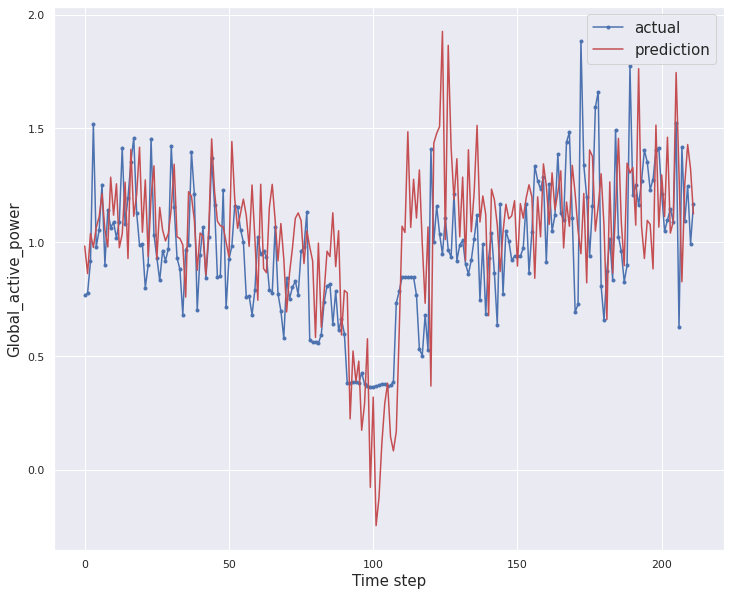

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Iteration-2

* Change learning rate to 0.0002
* Multiplied another CNN output which has a wider receptive field which smoothend the output

In [ ]:
inputs = Input(shape=(28,1), name='series')
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
conv1 = concatenate([conv1_a, conv1_b, conv1_c])
conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)

#conv1 = BatchNormalization()(conv1)
msblock = relu(conv1)
out = GlobalAveragePooling1D()(conv1)

# Flatten the ouput
#out = Flatten()(out)
out = Dense(units=64)(out)
out = Dense(units=192)(out)
out = relu(out)

attblock = Multiply()([out, msblock, conv2])
attblock = Flatten()(attblock)
attblock = Dense(units=1)(attblock)

model = Model(inputs, attblock, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_4 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_5 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_6 (Conv1D)               (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 17s 14ms/step - loss: 0.4170 - val_loss: 0.2002
Epoch 2/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2452 - val_loss: 0.1632
Epoch 3/100
120/120 [==============================] - 1s 7ms/step - loss: 0.2124 - val_loss: 0.1743
Epoch 4/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1948 - val_loss: 0.1426
Epoch 5/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1876 - val_loss: 0.1383
Epoch 6/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1840 - val_loss: 0.1352
Epoch 7/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1795 - val_loss: 0.1341
Epoch 8/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1731 - val_loss: 0.1262
Epoch 9/100
120/120 [==============================] - 1s 6ms/step - loss: 0.1655 - val_loss: 0.1301
Epoch 10/100
120/120 [==============================] - 1s 7ms/step - loss: 0.1614 - val_

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.13054193285030652
Validation rmse: 0.22860177627741324
MAPE: 20.408


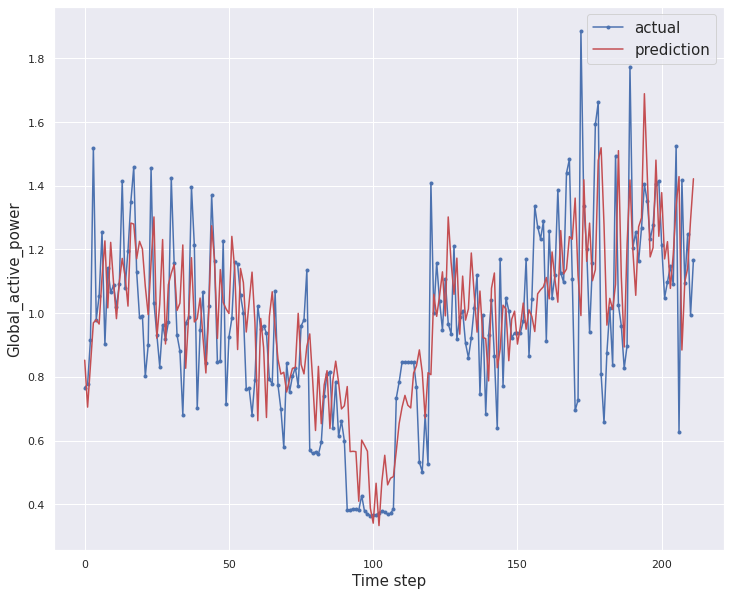

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## Iteration-3

* Add section - 2 from paper

In [ ]:
inputs = Input(shape=(28,1), name='series')


# Section - 1
#----------------------------------------------------------------------------------------
# Stack -1 
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)
#
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])

out = x * y

# Stack 2
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])
out = x * y
final_out = MaxPooling1D(3,2,padding='same')(out)


# Section - 2
# -----------------------------------------------------------------------------------
# Stack - 1
# Kernel filters = 128

#final_out = tf.reduce_mean(final_out, 1)
#final_out = Dense(units=1)(final_out)
conv1_a = Conv1D(filters=128,kernel_size=2, activation='relu',padding='same')(final_out)
conv1_b = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(final_out)
conv1_c = Conv1D(filters=128,kernel_size=14,activation='relu',padding='same')(final_out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])



out = x * y

final_out = tf.reduce_mean(out, 1)
final_out = Dense(units=1)(final_out)
model = Model(inputs,final_out, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_9 (Conv1D)               (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_10 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 9s 56ms/step - loss: 0.4367 - val_loss: 0.3836
Epoch 2/100
120/120 [==============================] - 6s 52ms/step - loss: 0.2422 - val_loss: 0.1390
Epoch 3/100
120/120 [==============================] - 6s 50ms/step - loss: 0.2023 - val_loss: 0.1308
Epoch 4/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2031 - val_loss: 0.1301
Epoch 5/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2022 - val_loss: 0.1300
Epoch 6/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2021 - val_loss: 0.1296
Epoch 7/100
120/120 [==============================] - 6s 52ms/step - loss: 0.2017 - val_loss: 0.1291
Epoch 8/100
120/120 [==============================] - 6s 51ms/step - loss: 0.2014 - val_loss: 0.1284
Epoch 9/100
120/120 [==============================] - 6s 50ms/step - loss: 0.2010 - val_loss: 0.1280
Epoch 10/100
120/120 [==============================] - 6s 50ms/step - loss: 0.199

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.16416826312625865
Validation rmse: 0.2284492447010035
MAPE: 21.031


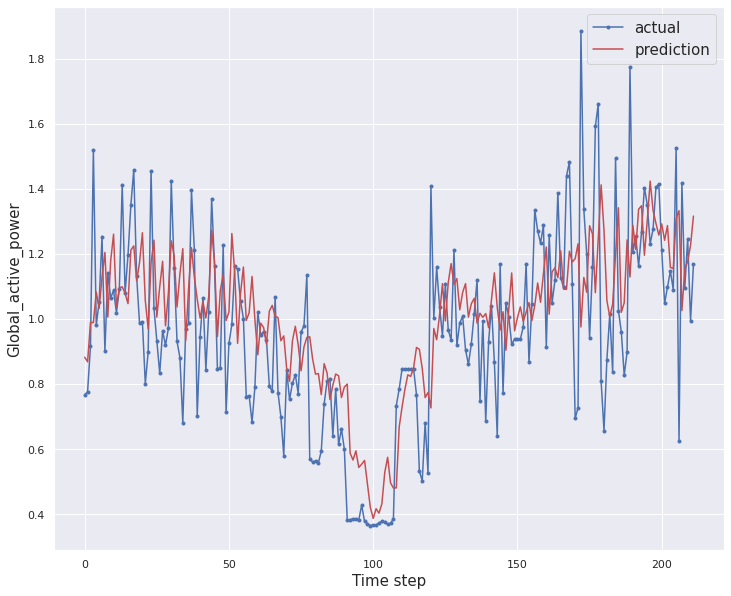

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


## Iteration-4

* Adding stack 2 of section -2

In [ ]:
inputs = Input(shape=(28,1), name='series')


# Section - 1
#----------------------------------------------------------------------------------------
# Stack -1 
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(inputs)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(inputs)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(inputs)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#conv2 = Conv1D(filters=192,kernel_size=21,activation='relu', padding='same')(inputs)
#
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])

out = x * y

# Stack 2
conv1_a = Conv1D(filters=64,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=64,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=64,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=12, use_bias=False,activation='relu')(y)
y = Dense(units=192,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,192])
out = x * y
final_out = MaxPooling1D(3,2,padding='same')(out)


# Section - 2
# -----------------------------------------------------------------------------------
# Stack - 1
# Kernel filters = 128

#final_out = tf.reduce_mean(final_out, 1)
#final_out = Dense(units=1)(final_out)
conv1_a = Conv1D(filters=128,kernel_size=2, activation='relu',padding='same')(final_out)
conv1_b = Conv1D(filters=128,kernel_size=7,activation='relu',padding='same')(final_out)
conv1_c = Conv1D(filters=128,kernel_size=14,activation='relu',padding='same')(final_out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])



out = x * y

# Stack 2
kernels = 128
conv1_a = Conv1D(filters=kernels,kernel_size=2, activation='relu',padding='same')(out)
conv1_b = Conv1D(filters=kernels,kernel_size=7,activation='relu',padding='same')(out)
conv1_c = Conv1D(filters=kernels,kernel_size=14,activation='relu',padding='same')(out)
x = concatenate([conv1_a, conv1_b, conv1_c], axis=2)
#x = BatchNormalization()(x)
x = relu(x)
y = tf.reduce_mean(x,1)

# Flatten the ouput
#out = Flatten()(out)
y = Dense(units=24, use_bias=False,activation='relu')(y)
y = Dense(units=384,use_bias=False,activation='relu')(y)
y= tf.reshape(y, [-1,1,384])

out = x * y
final_out = tf.reduce_mean(out, 1)
final_out = Dense(units=1)(final_out)
model = Model(inputs,final_out, name='MACNN')
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0002), loss='mean_absolute_error')
model.summary()




Model: "MACNN"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
series (InputLayer)             [(None, 28, 1)]      0                                            
__________________________________________________________________________________________________
conv1d_17 (Conv1D)              (None, 28, 64)       192         series[0][0]                     
__________________________________________________________________________________________________
conv1d_18 (Conv1D)              (None, 28, 64)       512         series[0][0]                     
__________________________________________________________________________________________________
conv1d_19 (Conv1D)              (None, 28, 64)       960         series[0][0]                     
______________________________________________________________________________________________

In [ ]:
model.fit(X_train_series,train_y, validation_data=(X_valid_series,test_y), epochs=100,batch_size=10, shuffle=False)

Epoch 1/100
120/120 [==============================] - 14s 95ms/step - loss: 0.4373 - val_loss: 0.4431
Epoch 2/100
120/120 [==============================] - 11s 88ms/step - loss: 0.3166 - val_loss: 0.1941
Epoch 3/100
120/120 [==============================] - 10s 87ms/step - loss: 0.2456 - val_loss: 0.1725
Epoch 4/100
120/120 [==============================] - 10s 87ms/step - loss: 0.2237 - val_loss: 0.1662
Epoch 5/100
120/120 [==============================] - 10s 87ms/step - loss: 0.2350 - val_loss: 0.1520
Epoch 6/100
120/120 [==============================] - 11s 88ms/step - loss: 0.2347 - val_loss: 0.1880
Epoch 7/100
120/120 [==============================] - 11s 88ms/step - loss: 0.2369 - val_loss: 0.1679
Epoch 8/100
120/120 [==============================] - 10s 87ms/step - loss: 0.2353 - val_loss: 0.1595
Epoch 9/100
120/120 [==============================] - 10s 87ms/step - loss: 0.2222 - val_loss: 0.1306
Epoch 10/100
120/120 [==============================] - 10s 87ms/step - l

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -1:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

macnn_train_pred = model.predict(X_train_series)
macnn_train_pred = macnn_train_pred.reshape(len(macnn_train_pred),1)
yhat = model.predict(X_valid_series)
print(train_y.shape)
#raise Exception
# invert scaling for forecast
yhat = yhat.reshape((len(yhat), 1))
inv_yhat_macnn = np.concatenate((yhat, test_X[:, -1:]), axis=1)
inv_yhat_macnn = scaler.inverse_transform(inv_yhat_macnn)
inv_yhat_macnn = inv_yhat_macnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, macnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_macnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_macnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




(1200,)
Train rmse: 0.16775406654053043
Validation rmse: 0.22970595496170476
MAPE: 20.840


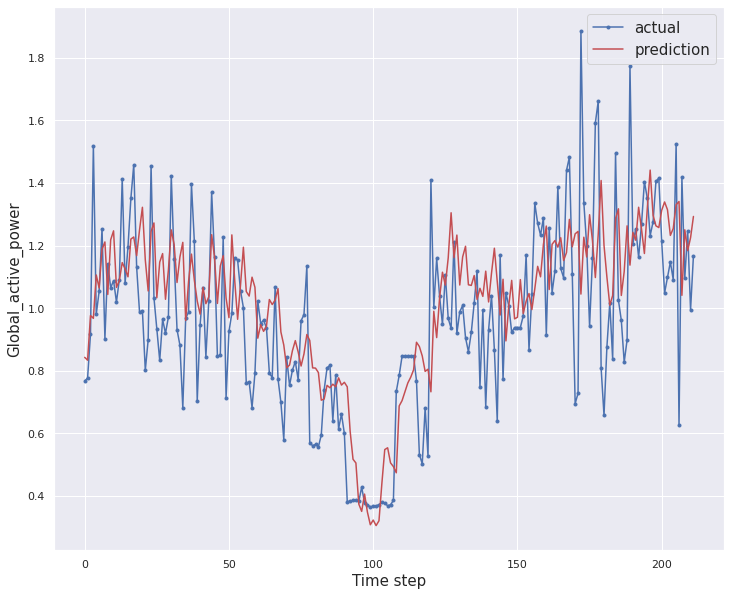

In [ ]:
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_macnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()


# **Hyperparameter Optimization**

* We will try to fine tune the basic architectures with the help of hyperparameter optimization
* Package used - Keras Tuner
* It helps to select the best hyperparameters for the tensorflow model
* We need to define a hyperparameter space for this

In [ ]:
pip install keras-tuner

     |████████████████████████████████| 102kB 3.0MB/s 
  Created wheel for kt-legacy: filename=kt_legacy-1.0.3-cp37-none-any.whl size=9569 sha256=27f6a1655afce52905c01f4ef9507ff33ec52e5237a113d2b4fdb0007db5684a
  Stored in directory: /root/.cache/pip/wheels/95/99/a8/6b116b0f69be60cc475d1cd36680f3a09f284d86655bb99d93
Successfully built kt-legacy


In [ ]:
import keras_tuner as kt # For hyperparameter optmization
from keras_tuner import RandomSearch

## Model-1(LSTM)

In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.38

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 1, 7) (1200,) (233, 1, 7) (233,)


In [ ]:
def build_model_lstm(hp):
  model = Sequential()
  model.add(LSTM(units=hp.Int("input_layer",min_value = 8, max_value = 256, step =16),
                       input_shape=(train_X.shape[1], train_X.shape[2]))),
  #model.add(Dropout(0.2))
  model.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_squared_error', optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2, 1e-3, 1e-4])))
  return model

In [ ]:
tuner = RandomSearch(build_model_lstm,
                     objective = "val_loss",
                     max_trials = 20,
                     executions_per_trial = 2,
                     overwrite= True
                     )
tuner.search_space_summary()
tuner.search(train_X, train_y, epochs=20, validation_data=(test_X, test_y))

Trial 20 Complete [00h 00m 12s]
val_loss: 0.018995676189661026

Best val_loss So Far: 0.018903298303484917
Total elapsed time: 00h 05m 35s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()
tuner.get_best_models(num_models= 1)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 152
Dense_1: 64
learning_rate: 0.01
Score: 0.018903298303484917
Trial summary
Hyperparameters:
input_layer: 136
Dense_1: 64
learning_rate: 0.01
Score: 0.018965779803693295
Trial summary
Hyperparameters:
input_layer: 216
Dense_1: 16
learning_rate: 0.01
Score: 0.018988012336194515
Trial summary
Hyperparameters:
input_layer: 184
Dense_1: 64
learning_rate: 0.01
Score: 0.01898997835814953
Trial summary
Hyperparameters:
input_layer: 168
Dense_1: 32
learning_rate: 0.01
Score: 0.01899290643632412
Trial summary
Hyperparameters:
input_layer: 136
Dense_1: 16
learning_rate: 0.01
Score: 0.018995676189661026
Trial summary
Hyperparameters:
input_layer: 24
Dense_1: 16
learning_rate: 0.01
Score: 0.019015243276953697
Trial summary
Hyperparameters:
input_layer: 136
Dense_1: 32
learning_rate: 0.01
Score: 0.019088280387222767
Trial summary
Hyperparamet

* Trying out the best model received from keras tuner

In [ ]:
model = Sequential()
model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(8, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30,  validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/500
40/40 - 3s - loss: 0.0434 - val_loss: 0.0083
Epoch 2/500
40/40 - 0s - loss: 0.0114 - val_loss: 0.0057
Epoch 3/500
40/40 - 0s - loss: 0.0110 - val_loss: 0.0055
Epoch 4/500
40/40 - 0s - loss: 0.0107 - val_loss: 0.0054
Epoch 5/500
40/40 - 0s - loss: 0.0104 - val_loss: 0.0053
Epoch 6/500
40/40 - 0s - loss: 0.0101 - val_loss: 0.0052
Epoch 7/500
40/40 - 0s - loss: 0.0101 - val_loss: 0.0052
Epoch 8/500
40/40 - 0s - loss: 0.0100 - val_loss: 0.0052
Epoch 9/500
40/40 - 0s - loss: 0.0100 - val_loss: 0.0052
Epoch 10/500
40/40 - 0s - loss: 0.0098 - val_loss: 0.0051
Epoch 11/500
40/40 - 0s - loss: 0.0097 - val_loss: 0.0052
Epoch 12/500
40/40 - 0s - loss: 0.0097 - val_loss: 0.0052
Epoch 13/500
40/40 - 0s - loss: 0.0096 - val_loss: 0.0052
Epoch 14/500
40/40 - 0s - loss: 0.0096 - val_loss: 0.0052
Epoch 15/500
40/40 - 0s - loss: 0.0097 - val_loss: 0.0052
Epoch 16/500
40/40 - 0s - loss: 0.0096 - val_loss: 0.0053
Epoch 17/500
40/40 - 0s - loss: 0.0097 - val_loss: 0.0053
Epoch 18/500
40/40 - 0s

Model: "sequential_42"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_96 (ModuleWra (None, 256)               270336    
_________________________________________________________________
module_wrapper_97 (ModuleWra (None, 256)               0         
_________________________________________________________________
module_wrapper_98 (ModuleWra (None, 8)                 2056      
_________________________________________________________________
module_wrapper_99 (ModuleWra (None, 1)                 9         
Total params: 272,401
Trainable params: 272,401
Non-trainable params: 0
_________________________________________________________________


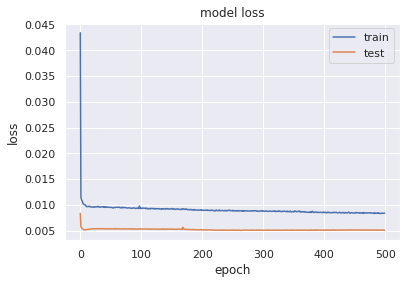

Test RMSE: 0.223
MAPE: 18.564


In [ ]:
model.summary()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X, batch_size=100)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse)
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)

* May be we can try with 200 epochs.
* Validation loss remains pretty constant after first few epochs
* Is it because model is not learning that much after that?

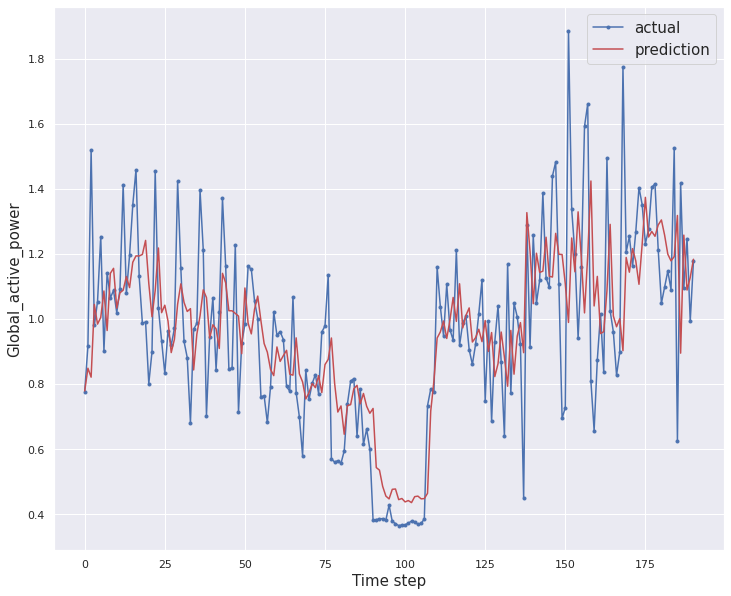

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len(test_X))]
plt.plot(aa, inv_y[:len(test_X)], marker='.', label="actual")
plt.plot(aa, inv_yhat_lstm[:len(test_X)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Iteration-2


In [ ]:
model = Sequential()
model.add(LSTM(152, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.1))
#    model.add(LSTM(70))
#    model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')



# fit network
history = model.fit(train_X, train_y, epochs=500, batch_size=30,  validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/500
40/40 - 3s - loss: 0.0941 - val_loss: 0.0198
Epoch 2/500
40/40 - 0s - loss: 0.0417 - val_loss: 0.0197
Epoch 3/500
40/40 - 0s - loss: 0.0396 - val_loss: 0.0194
Epoch 4/500
40/40 - 0s - loss: 0.0373 - val_loss: 0.0198
Epoch 5/500
40/40 - 0s - loss: 0.0376 - val_loss: 0.0198
Epoch 6/500
40/40 - 0s - loss: 0.0370 - val_loss: 0.0197
Epoch 7/500
40/40 - 0s - loss: 0.0368 - val_loss: 0.0197
Epoch 8/500
40/40 - 0s - loss: 0.0368 - val_loss: 0.0197
Epoch 9/500
40/40 - 0s - loss: 0.0363 - val_loss: 0.0200
Epoch 10/500
40/40 - 0s - loss: 0.0360 - val_loss: 0.0197
Epoch 11/500
40/40 - 0s - loss: 0.0365 - val_loss: 0.0199
Epoch 12/500
40/40 - 0s - loss: 0.0361 - val_loss: 0.0197
Epoch 13/500
40/40 - 0s - loss: 0.0360 - val_loss: 0.0195
Epoch 14/500
40/40 - 0s - loss: 0.0360 - val_loss: 0.0195
Epoch 15/500
40/40 - 0s - loss: 0.0358 - val_loss: 0.0193
Epoch 16/500
40/40 - 0s - loss: 0.0356 - val_loss: 0.0196
Epoch 17/500
40/40 - 0s - loss: 0.0356 - val_loss: 0.0192
Epoch 18/500
40/40 - 0s

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
module_wrapper_7 (ModuleWrap (None, 152)               97280     
_________________________________________________________________
module_wrapper_8 (ModuleWrap (None, 152)               0         
_________________________________________________________________
module_wrapper_9 (ModuleWrap (None, 64)                9792      
_________________________________________________________________
module_wrapper_10 (ModuleWra (None, 1)                 65        
Total params: 107,137
Trainable params: 107,137
Non-trainable params: 0
_________________________________________________________________


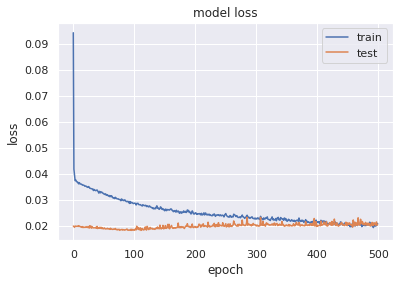

Test RMSE: 0.224
MAPE: 17.928


In [ ]:
model.summary()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

# make a prediction
yhat = model.predict(test_X, batch_size=30)
test_X = test_X.reshape((test_X.shape[0], 7))
# invert scaling for forecast
inv_yhat_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_lstm = scaler.inverse_transform(inv_yhat_lstm)
inv_yhat_lstm = inv_yhat_lstm[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y, inv_yhat_lstm))
print('Test RMSE: %.3f' % rmse)
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)

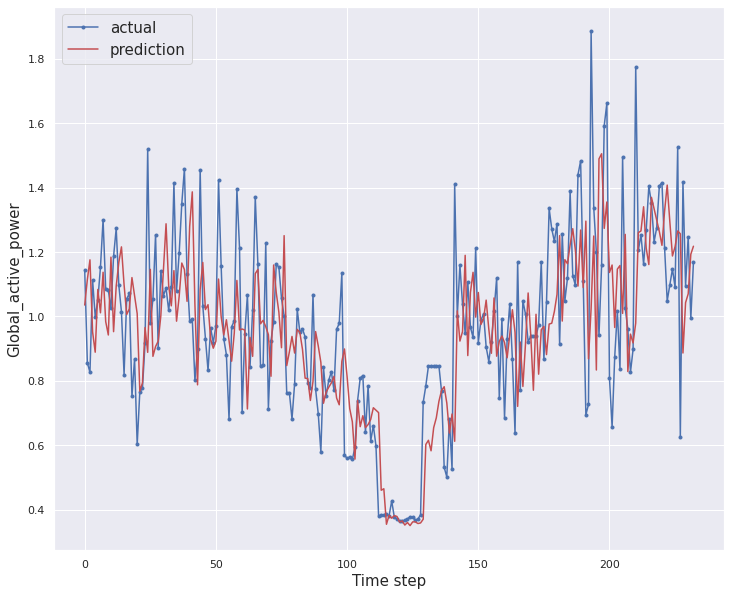

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_lstm[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Tune Hyperparameters- LSTM

#### Household Power Consumption Data

1
Train Data Dimensions: (1200, 2), Test Data Dimensions: (238, 2)
Epoch - 0
600/600 - 3s - loss: 0.1610
Inside Evaluate
(1200, 1, 1)
RMSE:0.168
Inside Evaluate
(238, 1, 1)
RMSE:0.114
Epoch - 1
600/600 - 1s - loss: 0.1568
Inside Evaluate
(1200, 1, 1)
RMSE:0.172
Inside Evaluate
(238, 1, 1)
RMSE:0.114
Epoch - 2
600/600 - 1s - loss: 0.1557
Inside Evaluate
(1200, 1, 1)
RMSE:0.181
Inside Evaluate
(238, 1, 1)
RMSE:0.121
Epoch - 3
600/600 - 1s - loss: 0.1548
Inside Evaluate
(1200, 1, 1)
RMSE:0.171
Inside Evaluate
(238, 1, 1)
RMSE:0.113
Epoch - 4
600/600 - 1s - loss: 0.1544
Inside Evaluate
(1200, 1, 1)
RMSE:0.183
Inside Evaluate
(238, 1, 1)
RMSE:0.121
Epoch - 5
600/600 - 1s - loss: 0.1532
Inside Evaluate
(1200, 1, 1)
RMSE:0.186
Inside Evaluate
(238, 1, 1)
RMSE:0.123
Epoch - 6
600/600 - 1s - loss: 0.1531
Inside Evaluate
(1200, 1, 1)
RMSE:0.196
Inside Evaluate
(238, 1, 1)
RMSE:0.130
Epoch - 7
600/600 - 1s - loss: 0.1533
Inside Evaluate
(1200, 1, 1)
RMSE:0.194
Inside Evaluate
(238, 1, 1)
RMSE:0.1

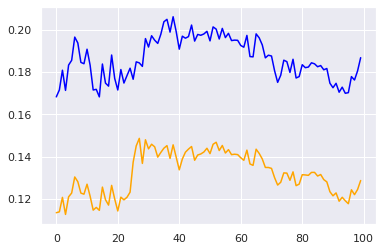

0) TrainRMSE=0.186773, TestRMSE=0.128731


<Figure size 432x288 with 0 Axes>

In [ ]:

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
  n_vars = 1 if type(data) is list else data.shape[1]
  print(n_vars)
  dff = pd.DataFrame(data)
  cols, names = list(), list()
  # input sequence (t-n, ... t-1)
  for i in range(n_in, 0, -1):
    cols.append(dff.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
  # forecast sequence (t, t+1, ... t+n)
  for i in range(0, n_out):
    cols.append(dff.shift(-i))
    if i == 0:
      names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
      names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
  # put it all together
  agg = pd.concat(cols, axis=1)
  agg.columns = names
  # drop rows with NaN values
  if dropnan:
    agg.dropna(inplace=True)
  return agg
 
# date-time parsing function for loading the dataset
def parser(x):
	return pd.datetime.strptime('190'+x, '%Y-%m')

# frame a sequence as a supervised learning problem
def timeseries_to_supervised(data, lag=1, dropnan = True):
  df = pd.DataFrame(data)
  columns = [df.shift(i) for i in range(1, lag+1)]
  columns.append(df)
  df = pd.concat(columns, axis=1)
  df = df.drop(0)
  if dropnan:
    df.dropna(inplace=True)
  return df

# create a differenced series
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.DataFrame(diff)

# scale train and test data to [-1, 1]
def scale(train, test):
  # fit scaler
  scaler = MinMaxScaler(feature_range=(-1, 1))
  scaler = scaler.fit(train)
  # transform train
  train = train.reshape(train.shape[0], train.shape[1])
  train_scaled = scaler.transform(train)
  # transform test
  test = test.reshape(test.shape[0], test.shape[1])
  test_scaled = scaler.transform(test)
  return scaler, train_scaled, test_scaled

# inverse scaling for a forecasted value
def invert_scale(scaler, X, yhat):
  #print("Inside Invert Scale")
  #print(X.shape)
  #print(yhat.shape)
  #raise Exception
  inverted = np.concatenate((X, yhat), axis = 1)
  inverted = scaler.inverse_transform(inverted)
  #print(inverted)
  return inverted[:,-1]

# evaluate the model on a dataset, returns RMSE in transformed units
def evaluate(model, raw_data, scaled_dataset, scaler, offset, batch_size):
  # separate
  X, y = scaled_dataset[:,0:-1], scaled_dataset[:,-1]
  print("Inside Evaluate")
  # reshape
  reshaped = X.reshape(len(X), 1, 1)
  print(reshaped.shape)
  # forecast dataset
  output = model.predict(reshaped, batch_size=batch_size)
  #print("Model Output")
  #print(output)
  #print(output.shape)
  # invert data transforms on forecast
  yhat = invert_scale(scaler, X, output)
  #print("YHAT")
  #print(yhat)
  #print(raw_data)
  # invert differencing
  #print("Invert Differencing")
  yhat = yhat.reshape(-1,1) + raw_data
  #print(yhat)
  # report performance
  rmse = np.sqrt(mean_squared_error(raw_data, yhat))
  print("RMSE:%.3f"%rmse)
  return rmse

# fit an LSTM network to training data
def fit_lstm(train, test, raw, scaler, batch_size, nb_epoch, neurons):
  X, y = train[:, 0:-1], train[:, -1]
  #print("Inside LSTM call")
  #print(test.shape)
  #print(train)
  #print(X)
  X = X.reshape(X.shape[0], 1, X.shape[1])
  #print("After Reshape")
  # prepare model
  model = Sequential()
  model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer='adam')
  #model.summary()
  # fit model
  train_rmse, test_rmse = list(), list()
  for i in range(nb_epoch):
    print("Epoch - %d" %(i))
    model.fit(X, y, epochs=1, batch_size=batch_size, verbose=2, shuffle=False)
    model.reset_states()
    # evaluate model on train data
    #print("Raw Data")
    raw_train = raw[-(len(train)+len(test)+1):-len(test)-1]
    #print(raw_train)
    #print(raw_train.shape)
    #print(raw_train)
    train_rmse.append(evaluate(model, raw_train, train, scaler, 0, batch_size))
    model.reset_states()
    # evaluate model on test data
    raw_test = raw[-(len(test)):]
    #print(raw_test.shape)
    test_rmse.append(evaluate(model, raw_test, test, scaler, 0, batch_size))
    model.reset_states()
  history = pd.DataFrame()
  history['train'], history['test'] = train_rmse, test_rmse
  #print(history)
  return history

# run diagnostic experiments
def run():
  # load dataset
  series = df_resample_day.loc[:,['Global_active_power']]
  #series = pd.read_csv('shampoo.csv', header=0, parse_dates=[0], index_col=0, squeeze=True, date_parser=parser)
  # transform data to be 
  #("Original Data")
  series.dropna(inplace = True)
  raw_values = series.values
  #print(raw_values.shape)
  #print(raw_values)
  diff_values = difference(raw_values, 1)
  #print("After Taking First Difference")
  #print(diff_values)
  #print(type(diff_values))
  # transform data to be supervised learning
  #supervised = timeseries_to_supervised(diff_values, 1)
  supervised = series_to_supervised(diff_values, 1, 1)
  supervised_values = supervised.values
  #print("After taking a lag")
  #print(supervised_values)
  # split data into train and test-sets
  train, test = supervised_values[0:1200], supervised_values[1200:]
  print("Train Data Dimensions: %s, Test Data Dimensions: %s" %(train.shape, test.shape))
  # transform the scale of the data
  scaler, train_scaled, test_scaled = scale(train, test)
  # fit and evaluate model
  #print(train_scaled)
  #train_trimmed = train_scaled[2:, :]
  # config
  #repeats = 10
  repeats = 1
  n_batch = 2
  #n_epochs = 500
  n_epochs = 100
  n_neurons = 128
  #raise Exception
  # run diagnostic tests
  for i in range(repeats):
    history = fit_lstm(train_scaled, test_scaled, raw_values, scaler, n_batch, n_epochs, n_neurons)
    plt.plot(history['train'], color='blue')
    plt.plot(history['test'], color='orange')
    plt.show()
    print('%d) TrainRMSE=%f, TestRMSE=%f' % (i, history['train'].iloc[-1], history['test'].iloc[-1]))
  plt.savefig('epochs_diagnostic.png')

run()

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(raw_test)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, raw_test[:n], marker='.', label="actual")
plt.plot(aa, yhat[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Model-2(CNN)

In [ ]:
df_resample_day_y = df_resample_day.loc[:,['Global_active_power']]
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
values = df_resample_day_y.values
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(values)

print(type(scaled))
print(scaled.shape)
print(pd.DataFrame(scaled))
# frame as supervised learning
reframed = series_to_supervised(scaled, 7, 1)
print(reframed)

<class 'numpy.ndarray'>
(1440, 1)
             0
0    -0.136197
1    -0.373925
2    -0.126504
3    -0.348679
4    -0.075393
...        ...
1435 -0.207958
1436 -0.413127
1437 -0.316418
1438 -0.477850
1439 -0.367155

[1440 rows x 1 columns]
1
      var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7     -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8     -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9     -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10    -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11    -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964
...         ...        ...        ...  ...        ...        ...       ...
1435  -0.338026  -0.443102  -0.411139  ...  -0.139213  -0.712315 -0.207958
1436  -0.443102  -0.411139  -0.380134  ...  -0.712315  -0.207958 -0.413127
1437  -0.411139  -0.380134  -0.416283  ...  -0.207958  -0.413127 -0.316418
1438  -0.

In [ ]:
## * Note: I scale all features in range of [0,1].

## If you would like to train based on the resampled data (over hour), then used below
#values = df_resample.values 

#print(values.shape)
## full data without resampling
#values = df.values

# integer encode direction
# ensure all data is float
#values = values.astype('float32')
# normalize features
#scaler = MinMaxScaler(feature_range=(0, 1))
#scaled = scaler.fit_transform(values)
# frame as supervised learning
#reframed = series_to_supervised(scaled, 7, 1)
#print(reframed.shape)
print('var1' in reframed.columns)
reframed = reframed.filter(regex = '^var1', axis = 1)
# drop columns we don't want to predict
#reframed.drop(reframed.columns[[8,9,10,11,12,13]], axis=1, inplace=True)
print(reframed.head())

False
    var1(t-7)  var1(t-6)  var1(t-5)  ...  var1(t-2)  var1(t-1)   var1(t)
7   -0.136197  -0.373925  -0.126504  ...   1.000000   0.016878  0.102266
8   -0.373925  -0.126504  -0.348679  ...   0.016878   0.102266  0.628892
9   -0.126504  -0.348679  -0.075393  ...   0.102266   0.628892 -0.434695
10  -0.348679  -0.075393   1.000000  ...   0.628892  -0.434695 -0.194205
11  -0.075393   1.000000   0.016878  ...  -0.434695  -0.194205  0.292964

[5 rows x 8 columns]


In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
# def build_model(hp):
#   model_cnn = Sequential()
#   model_cnn.add(Conv1D(filters=hp.Int("input_layer",min_value = 32, max_value = 512, step =32),
#                        kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]))),
#   for i in range(hp.Int("num_layers", 2, 5)):
#     model_cnn.add(Conv1D(filters=hp.Int("filters_"+str(i), min_value = 32, max_value = 256, step = 32),
#                          kernel_size = 2, activation = 'relu'))
#     #model_cnn.add(MaxPooling1D(pool_size=2, padding='same'))
#   model_cnn.add(Flatten())
#   model_cnn.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
#   model_cnn.add(Dense(1))
#   model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2, 1e-3, 1e-4])))
#   return model_cnn

def build_model(hp):
  model_cnn = Sequential()
  model_cnn.add(Conv1D(filters=hp.Int("input_layer",min_value = 32, max_value = 512, step =32),
                       kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2]))),
  model_cnn.add(MaxPooling1D(pool_size=2, padding='same'))
  model_cnn.add(Flatten())
  model_cnn.add(Dense(hp.Choice("Dense_1", [8, 16, 32, 64]), activation='relu'))
  model_cnn.add(Dense(1))
  model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2, 1e-3, 1e-4])))
  return model_cnn


In [ ]:
tuner = RandomSearch(build_model,
                     objective = "val_loss",
                     max_trials = 20,
                     executions_per_trial = 2,
                     overwrite= True,
                     seed=6421
                     )
tuner.search_space_summary()
tuner.search(X_train_series, train_y, epochs=20, validation_data=(X_valid_series, test_y))

Trial 20 Complete [00h 00m 09s]
val_loss: 0.02007085084915161

Best val_loss So Far: 0.01931687816977501
Total elapsed time: 00h 03m 04s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()
tuner.get_best_models(num_models= 1)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
input_layer: 224
Dense_1: 64
learning_rate: 0.01
Score: 0.01931687816977501
Trial summary
Hyperparameters:
input_layer: 320
Dense_1: 64
learning_rate: 0.01
Score: 0.019473464228212833
Trial summary
Hyperparameters:
input_layer: 320
Dense_1: 32
learning_rate: 0.01
Score: 0.019541174173355103
Trial summary
Hyperparameters:
input_layer: 96
Dense_1: 8
learning_rate: 0.01
Score: 0.019603263586759567
Trial summary
Hyperparameters:
input_layer: 352
Dense_1: 8
learning_rate: 0.01
Score: 0.01977363880723715
Trial summary
Hyperparameters:
input_layer: 448
Dense_1: 64
learning_rate: 0.001
Score: 0.01979827880859375
Trial summary
Hyperparameters:
input_layer: 288
Dense_1: 64
learning_rate: 0.001
Score: 0.01980811543762684
Trial summary
Hyperparameters:
input_layer: 192
Dense_1: 64
learning_rate: 0.001
Score: 0.019874186255037785
Trial summary
Hyperparamete

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(16, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.001))
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 1s - loss: 0.0292 - val_loss: 0.0055
Epoch 2/20
38/38 - 0s - loss: 0.0111 - val_loss: 0.0055
Epoch 3/20
38/38 - 0s - loss: 0.0107 - val_loss: 0.0055
Epoch 4/20
38/38 - 0s - loss: 0.0105 - val_loss: 0.0059
Epoch 5/20
38/38 - 0s - loss: 0.0103 - val_loss: 0.0054
Epoch 6/20
38/38 - 0s - loss: 0.0102 - val_loss: 0.0055
Epoch 7/20
38/38 - 0s - loss: 0.0101 - val_loss: 0.0054
Epoch 8/20
38/38 - 0s - loss: 0.0100 - val_loss: 0.0054
Epoch 9/20
38/38 - 0s - loss: 0.0099 - val_loss: 0.0054
Epoch 10/20
38/38 - 0s - loss: 0.0099 - val_loss: 0.0055
Epoch 11/20
38/38 - 0s - loss: 0.0099 - val_loss: 0.0054
Epoch 12/20
38/38 - 0s - loss: 0.0099 - val_loss: 0.0056
Epoch 13/20
38/38 - 0s - loss: 0.0097 - val_loss: 0.0057
Epoch 14/20
38/38 - 0s - loss: 0.0096 - val_loss: 0.0056
Epoch 15/20
38/38 - 0s - loss: 0.0097 - val_loss: 0.0055
Epoch 16/20
38/38 - 0s - loss: 0.0095 - val_loss: 0.0053
Epoch 17/20
38/38 - 0s - loss: 0.0098 - val_loss: 0.0061
Epoch 18/20
38/38 - 0s - loss: 0.0097 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn.predict(X_train_series)
yhat = model_cnn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_cnn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn = scaler.inverse_transform(inv_yhat_cnn)
inv_yhat_cnn = inv_yhat_cnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



Train rmse: 0.09780012562502544
Validation rmse: 0.23012004644681475
MAPE: 17.402


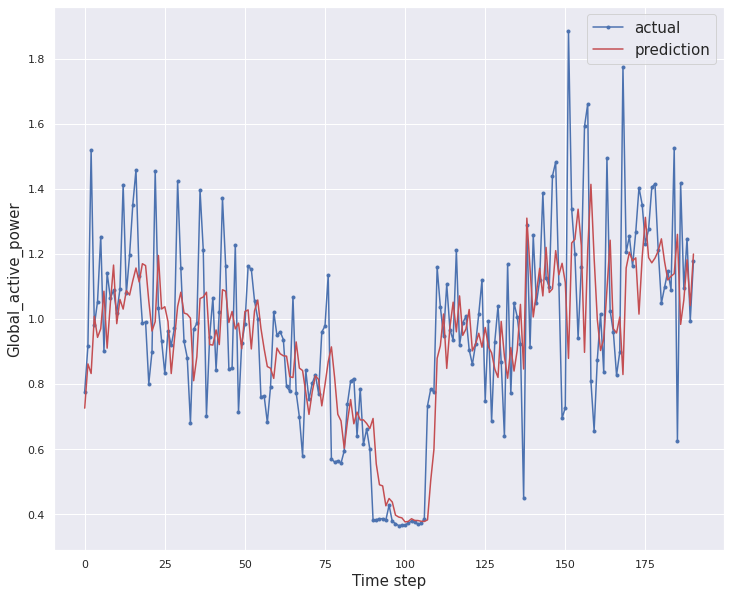

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len(test_y))]
plt.plot(aa, inv_y[:len(test_y)], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn[:len(test_y)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Iteration-2

In [ ]:
model_cnn = Sequential()
model_cnn.add(Conv1D(filters=224, kernel_size=2, activation='relu', input_shape=(X_train_series.shape[1], X_train_series.shape[2])))
model_cnn.add(MaxPooling1D(pool_size=2))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dense(1))
model_cnn.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01))
#model_cnn.summary()

In [ ]:
cnn_history = model_cnn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 1s - loss: 0.0597 - val_loss: 0.0210
Epoch 2/20
38/38 - 0s - loss: 0.0405 - val_loss: 0.0210
Epoch 3/20
38/38 - 0s - loss: 0.0383 - val_loss: 0.0224
Epoch 4/20
38/38 - 0s - loss: 0.0408 - val_loss: 0.0220
Epoch 5/20
38/38 - 0s - loss: 0.0385 - val_loss: 0.0267
Epoch 6/20
38/38 - 0s - loss: 0.0394 - val_loss: 0.0233
Epoch 7/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0221
Epoch 8/20
38/38 - 0s - loss: 0.0373 - val_loss: 0.0204
Epoch 9/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0222
Epoch 10/20
38/38 - 0s - loss: 0.0393 - val_loss: 0.0200
Epoch 11/20
38/38 - 0s - loss: 0.0363 - val_loss: 0.0213
Epoch 12/20
38/38 - 0s - loss: 0.0367 - val_loss: 0.0226
Epoch 13/20
38/38 - 0s - loss: 0.0361 - val_loss: 0.0243
Epoch 14/20
38/38 - 0s - loss: 0.0365 - val_loss: 0.0215
Epoch 15/20
38/38 - 0s - loss: 0.0361 - val_loss: 0.0260
Epoch 16/20
38/38 - 0s - loss: 0.0373 - val_loss: 0.0201
Epoch 17/20
38/38 - 0s - loss: 0.0341 - val_loss: 0.0223
Epoch 18/20
38/38 - 0s - loss: 0.0365 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn.predict(X_train_series)
yhat = model_cnn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_cnn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn = scaler.inverse_transform(inv_yhat_cnn)
inv_yhat_cnn = inv_yhat_cnn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)



Train rmse: 0.18173802534422628
Validation rmse: 0.22122530129346937
MAPE: 19.635


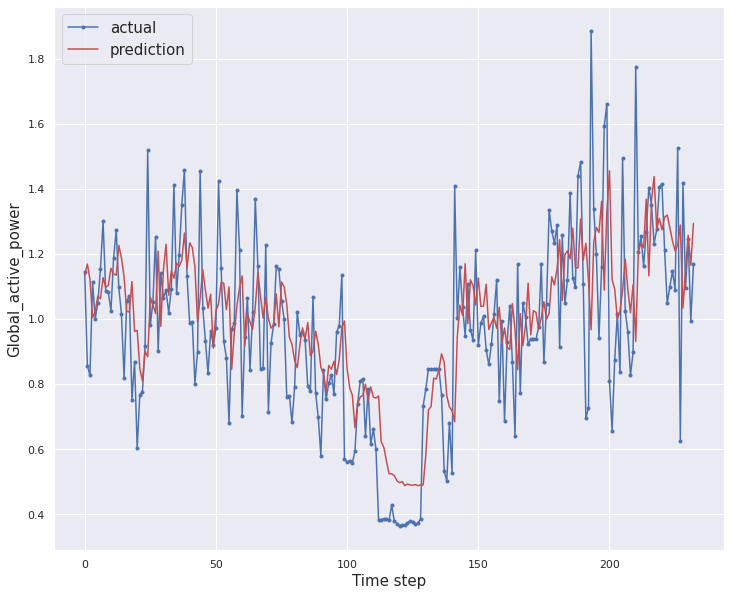

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Model-3(CNN+LSTM)

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
subsequences = 1
timesteps = train_X.shape[1]//subsequences
print(timesteps)
X_train_series_sub = train_X.reshape((train_X.shape[0], subsequences, timesteps, 1))
X_valid_series_sub = test_X.reshape((test_X.shape[0], subsequences, timesteps, 1))
print('Train set shape', X_train_series_sub.shape)
print('Validation set shape', X_valid_series_sub.shape)

7
Train set shape (1200, 1, 7, 1)
Validation set shape (233, 1, 7, 1)


In [ ]:
def build_cnn_lstm_hybrid_model(hp):
  model = Sequential()
  model.add(TimeDistributed(Conv1D(hp.Int("cnn_input", min_value = 32, max_value = 512, step = 32),
                                   kernel_size=2, activation='relu'), input_shape = (None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
  model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
  model.add(TimeDistributed(Flatten()))
  model.add(LSTM(hp.Choice("units", [8,16,32,64,128,256]), activation='relu'))
  model.add(Dense(1))
  model.compile(loss='mean_absolute_error', optimizer=keras.optimizers.Adam(hp.Choice("learning_rate",[1e-2,1e-3,1e-4])))
  return model


In [ ]:
tuner = RandomSearch(build_cnn_lstm_hybrid_model,
                     objective = "val_loss",
                     max_trials = 20,
                     executions_per_trial = 2,
                     overwrite= True,
                     seed= 6421
                     )
tuner.search_space_summary()
tuner.search(X_train_series_sub, train_y, epochs=20, validation_data=(X_valid_series_sub, test_y))

Trial 20 Complete [00h 00m 24s]
val_loss: 0.10115351527929306

Best val_loss So Far: 0.10048704966902733
Total elapsed time: 00h 09m 43s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()
tuner.get_best_models(num_models= 1)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
cnn_input: 224
units: 64
learning_rate: 0.01
Score: 0.10048704966902733
Trial summary
Hyperparameters:
cnn_input: 320
units: 32
learning_rate: 0.01
Score: 0.10115351527929306
Trial summary
Hyperparameters:
cnn_input: 384
units: 8
learning_rate: 0.01
Score: 0.1013125628232956
Trial summary
Hyperparameters:
cnn_input: 480
units: 8
learning_rate: 0.01
Score: 0.10199308767914772
Trial summary
Hyperparameters:
cnn_input: 320
units: 256
learning_rate: 0.01
Score: 0.10222170874476433
Trial summary
Hyperparameters:
cnn_input: 352
units: 8
learning_rate: 0.01
Score: 0.10265146568417549
Trial summary
Hyperparameters:
cnn_input: 128
units: 128
learning_rate: 0.01
Score: 0.10294145345687866
Trial summary
Hyperparameters:
cnn_input: 448
units: 8
learning_rate: 0.01
Score: 0.10297483950853348
Trial summary
Hyperparameters:
cnn_input: 96
units: 8
learning_rat

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=416, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01))
#model_cnn_lstm.summary()

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 2s - loss: 0.0707 - val_loss: 0.0305
Epoch 2/20
38/38 - 0s - loss: 0.0433 - val_loss: 0.0220
Epoch 3/20
38/38 - 0s - loss: 0.0413 - val_loss: 0.0220
Epoch 4/20
38/38 - 0s - loss: 0.0416 - val_loss: 0.0216
Epoch 5/20
38/38 - 0s - loss: 0.0400 - val_loss: 0.0293
Epoch 6/20
38/38 - 0s - loss: 0.0386 - val_loss: 0.0207
Epoch 7/20
38/38 - 0s - loss: 0.0384 - val_loss: 0.0212
Epoch 8/20
38/38 - 0s - loss: 0.0380 - val_loss: 0.0249
Epoch 9/20
38/38 - 0s - loss: 0.0372 - val_loss: 0.0265
Epoch 10/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0314
Epoch 11/20
38/38 - 0s - loss: 0.0374 - val_loss: 0.0227
Epoch 12/20
38/38 - 0s - loss: 0.0383 - val_loss: 0.0308
Epoch 13/20
38/38 - 0s - loss: 0.0389 - val_loss: 0.0258
Epoch 14/20
38/38 - 0s - loss: 0.0364 - val_loss: 0.0234
Epoch 15/20
38/38 - 0s - loss: 0.0350 - val_loss: 0.0222
Epoch 16/20
38/38 - 0s - loss: 0.0350 - val_loss: 0.0198
Epoch 17/20
38/38 - 0s - loss: 0.0349 - val_loss: 0.0221
Epoch 18/20
38/38 - 0s - loss: 0.0345 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn_lstm.predict(X_train_series_sub)

yhat = model_cnn_lstm.predict(X_valid_series_sub)
# invert scaling for forecast
inv_yhat_cnn_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn_lstm = scaler.inverse_transform(inv_yhat_cnn_lstm)
inv_yhat_cnn_lstm = inv_yhat_cnn_lstm[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn_lstm)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




Train rmse: 0.1823107093275337
Validation rmse: 0.22275129649530634
MAPE: 16.507


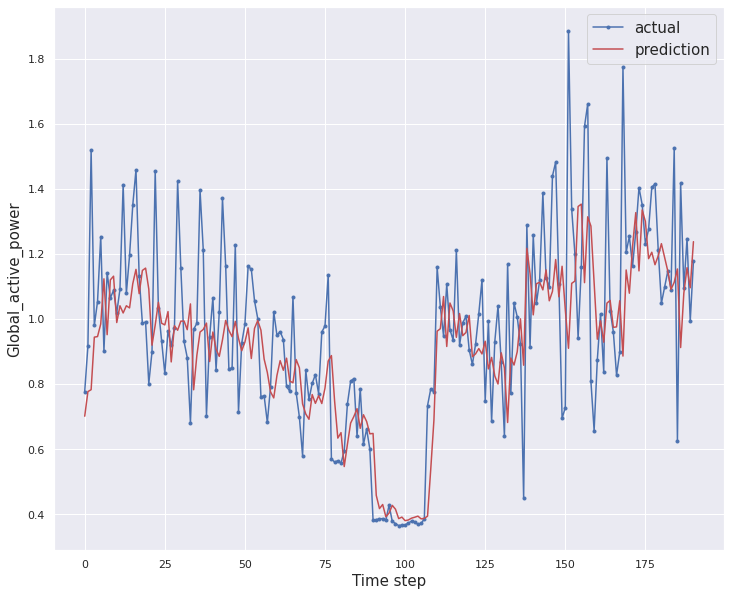

In [ ]:
## time steps, every step is one hour one day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len  (test_y))]
plt.plot(aa, inv_y[:len(test_y)], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn_lstm[:len(test_y)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Iteration-2

In [ ]:
model_cnn_lstm = Sequential()
model_cnn_lstm.add(TimeDistributed(Conv1D(filters=224, kernel_size=2, activation='relu'), input_shape=(None, X_train_series_sub.shape[2], X_train_series_sub.shape[3])))
model_cnn_lstm.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model_cnn_lstm.add(TimeDistributed(Flatten()))
model_cnn_lstm.add(LSTM(64, activation='relu'))
model_cnn_lstm.add(Dense(1))
model_cnn_lstm.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=0.01))
#model_cnn_lstm.summary()

In [ ]:
cnn_lstm_history = model_cnn_lstm.fit(X_train_series_sub, train_y, validation_data=(X_valid_series_sub, test_y), epochs=20, verbose=2)

Epoch 1/20
38/38 - 2s - loss: 0.0635 - val_loss: 0.0238
Epoch 2/20
38/38 - 0s - loss: 0.0408 - val_loss: 0.0219
Epoch 3/20
38/38 - 0s - loss: 0.0389 - val_loss: 0.0210
Epoch 4/20
38/38 - 0s - loss: 0.0399 - val_loss: 0.0278
Epoch 5/20
38/38 - 0s - loss: 0.0394 - val_loss: 0.0307
Epoch 6/20
38/38 - 0s - loss: 0.0395 - val_loss: 0.0206
Epoch 7/20
38/38 - 0s - loss: 0.0385 - val_loss: 0.0201
Epoch 8/20
38/38 - 0s - loss: 0.0372 - val_loss: 0.0205
Epoch 9/20
38/38 - 0s - loss: 0.0362 - val_loss: 0.0198
Epoch 10/20
38/38 - 0s - loss: 0.0369 - val_loss: 0.0200
Epoch 11/20
38/38 - 0s - loss: 0.0361 - val_loss: 0.0199
Epoch 12/20
38/38 - 0s - loss: 0.0370 - val_loss: 0.0208
Epoch 13/20
38/38 - 0s - loss: 0.0359 - val_loss: 0.0199
Epoch 14/20
38/38 - 0s - loss: 0.0359 - val_loss: 0.0194
Epoch 15/20
38/38 - 0s - loss: 0.0340 - val_loss: 0.0205
Epoch 16/20
38/38 - 0s - loss: 0.0355 - val_loss: 0.0193
Epoch 17/20
38/38 - 0s - loss: 0.0332 - val_loss: 0.0252
Epoch 18/20
38/38 - 0s - loss: 0.0357 - 

In [ ]:


# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

cnn_train_pred = model_cnn_lstm.predict(X_train_series_sub)

yhat = model_cnn_lstm.predict(X_valid_series_sub)
# invert scaling for forecast
inv_yhat_cnn_lstm = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_cnn_lstm = scaler.inverse_transform(inv_yhat_cnn_lstm)
inv_yhat_cnn_lstm = inv_yhat_cnn_lstm[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, cnn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_cnn_lstm)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_cnn_lstm)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)




Train rmse: 0.17565486955142426
Validation rmse: 0.22244288478303795
MAPE: 20.519


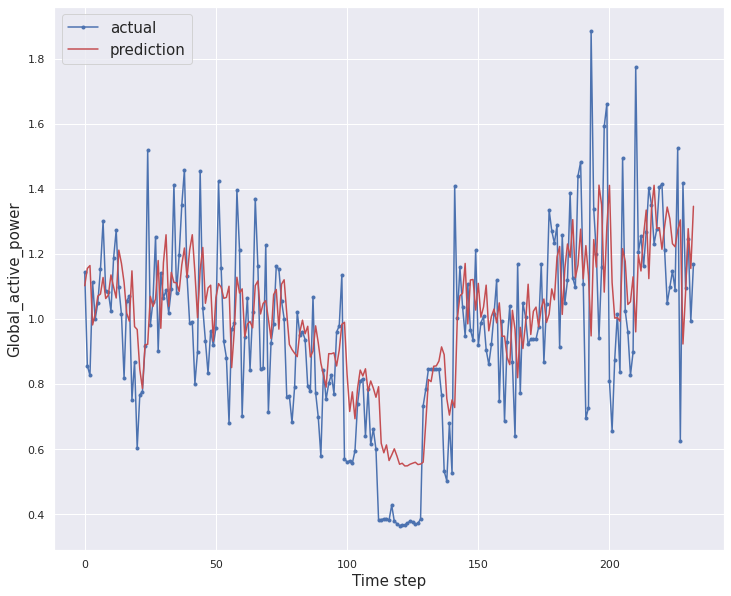

In [ ]:
## time steps, every step is one hour one day (you can easily convert the time step to the actual time index)
## 
n = len(test_X)
fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(n)]
plt.plot(aa, inv_y[:n], marker='.', label="actual")
plt.plot(aa, inv_yhat_cnn_lstm[:n], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

## Model-4(TCN)

In [ ]:
# split into train and test sets
values = reframed.values

n_train_time = 1200
train = values[:n_train_time, :]
test = values[n_train_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
#train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
#test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape) 
# We reshaped the input into the 3D format as expected by LSTMs, namely [samples, timesteps, features].

(1200, 7) (1200,) (233, 7) (233,)


In [ ]:
X_train_series = train_X.reshape((train_X.shape[0], train_X.shape[1], 1))
X_valid_series = test_X.reshape((test_X.shape[0], test_X.shape[1], 1))
print('Train set shape', X_train_series.shape)
print('Validation set shape', X_valid_series.shape)

Train set shape (1200, 7, 1)
Validation set shape (233, 7, 1)


In [ ]:
def build_tcn_model(hp):
  tcn_layer = TCN(input_shape=(7,1),
                  nb_filters = hp.Int("filter", min_value=32, max_value=512, step=32),
                  dilations =(1,2,4,8),
                  activation ='relu',
                  use_skip_connections = True)
  model = Sequential([tcn_layer, Dense(1)])
  model.compile(loss='mean_absolute_error', 
                optimizer=keras.optimizers.Adam(learning_rate=hp.Choice("learning_rate",[1e-2,1e-3,1e-4])))
  return model

In [ ]:
tuner = RandomSearch(build_tcn_model,
                     objective = "val_loss",
                     max_trials = 20,
                     executions_per_trial = 2,
                     overwrite= True,
                     seed= 6421
                     )
tuner.search_space_summary()
tuner.search(X_train_series, train_y, epochs=20, validation_data=(X_valid_series, test_y))

Search space summary
Default search space size: 2
filter (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}

Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
filter            |448               |?                 
learning_rate     |0.001             |?                 

Epoch 1/20


KeyboardInterrupt: ignored

In [ ]:
tuner.results_summary()
tuner.get_best_models(num_models= 1)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 64
learning_rate: 0.01
Score: 0.1031135693192482
Trial summary
Hyperparameters:
filter: 352
learning_rate: 0.01
Score: 0.10400186851620674
Trial summary
Hyperparameters:
filter: 448
learning_rate: 0.001
Score: 0.10475891456007957
Trial summary
Hyperparameters:
filter: 352
learning_rate: 0.001
Score: 0.1049308255314827
Trial summary
Hyperparameters:
filter: 64
learning_rate: 0.001
Score: 0.10501281172037125
Trial summary
Hyperparameters:
filter: 256
learning_rate: 0.01
Score: 0.10509878396987915
Trial summary
Hyperparameters:
filter: 480
learning_rate: 0.001
Score: 0.10529870167374611
Trial summary
Hyperparameters:
filter: 384
learning_rate: 0.01
Score: 0.10588320344686508
Trial summary
Hyperparameters:
filter: 416
learning_rate: 0.001
Score: 0.10597335919737816
Trial summary
Hyperparameters:
filter: 288
learning_rate: 0.0001
Score: 0.10

In [ ]:
# if time_steps > tcn_layer.receptive_field, then we should not
# be able to solve this task.

tcn_layer = TCN(input_shape=(7, 1),
                nb_filters = 32,
                dilations = (1,2,4,8),
                activation = 'relu',
                use_skip_connections = True)

# The receptive field tells you how far the model can see in terms of timesteps.
print('Receptive field size =', tcn_layer.receptive_field)

model_tcn = Sequential([
    tcn_layer,
    Dense(1)
])

model_tcn.compile(optimizer=keras.optimizers.Adam(learning_rate=0.01), loss='mae')
model_tcn.summary()
#tcn_full_summary(m, expand_residual_blocks=False)

model_tcn.fit(X_train_series, train_y, validation_data=(X_valid_series, test_y), epochs=20)

Receptive field size = 61
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
tcn_1 (TCN)                  (None, 32)                21920     
_________________________________________________________________
module_wrapper_1 (ModuleWrap (None, 1)                 33        
Total params: 21,953
Trainable params: 21,953
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
38/38 [==============================] - 2s 13ms/step - loss: 0.3166 - val_loss: 0.1295
Epoch 2/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1567 - val_loss: 0.1205
Epoch 3/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1483 - val_loss: 0.1168
Epoch 4/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1440 - val_loss: 0.1345
Epoch 5/20
38/38 [==============================] - 0s 6ms/step - loss: 0.1472 - val_loss: 0.

In [ ]:

# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = np.concatenate((test_y, test_X[:, -6:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]

tcn_train_pred = model_tcn.predict(X_train_series)

yhat = model_tcn.predict(X_valid_series)
# invert scaling for forecast
inv_yhat_tcn = np.concatenate((yhat, test_X[:, -6:]), axis=1)
inv_yhat_tcn = scaler.inverse_transform(inv_yhat_tcn)
inv_yhat_tcn = inv_yhat_tcn[:,0]
print('Train rmse:', np.sqrt(mean_squared_error(train_y, tcn_train_pred)))
print('Validation rmse:', np.sqrt(mean_squared_error(inv_y, inv_yhat_tcn)))
loss = tf.keras.losses.mean_absolute_percentage_error(inv_y, inv_yhat_tcn)
#mape_lst.append(loss)
print('MAPE: %.3f' % loss)


Train rmse: 0.1820834469885907
Validation rmse: 0.24099882564148373
MAPE: 18.863


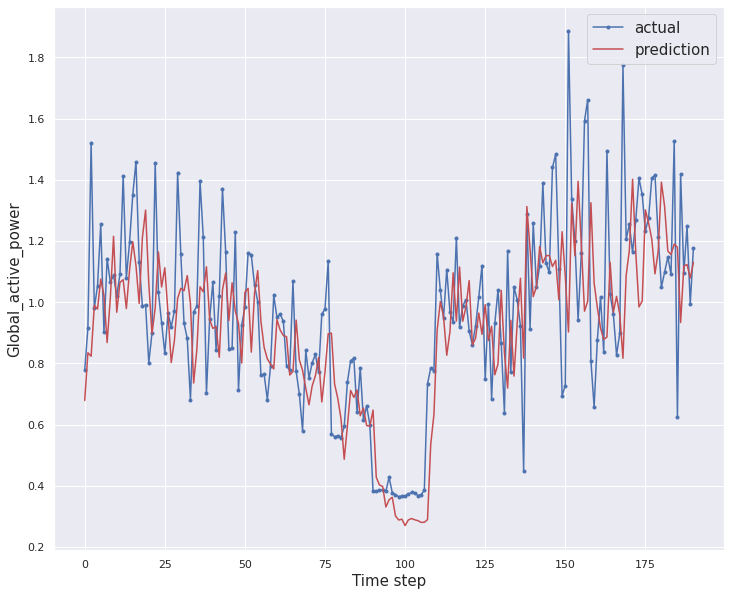

In [ ]:
## time steps, every step is one hourone day (you can easily convert the time step to the actual time index)
## 

fig, ax = plt.subplots(figsize = (12,10))
aa=[x for x in range(len(test_y))]
plt.plot(aa, inv_y[:len(test_y)], marker='.', label="actual")
plt.plot(aa, inv_yhat_tcn[:len(test_y)], 'r', label="prediction")
plt.ylabel('Global_active_power', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### Bayesian Optimization

In [ ]:
from keras_tuner import BayesianOptimization

In [ ]:
bay_tuner = BayesianOptimization(build_tcn_model,
                     objective = "val_loss",
                     max_trials = 20,
                     executions_per_trial = 2,
                     overwrite= True,
                     seed= 6421
                     )
bay_tuner.search_space_summary()
bay_tuner.search(X_train_series, train_y, epochs=20, validation_data=(X_valid_series, test_y))

Trial 20 Complete [00h 00m 12s]
val_loss: 0.1018957570195198

Best val_loss So Far: 0.1018957570195198
Total elapsed time: 00h 06m 42s
INFO:tensorflow:Oracle triggered exit


In [ ]:
bay_tuner.results_summary()
bay_tuner.get_best_models(num_models= 1)

Results summary
Results in ./untitled_project
Showing 10 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.1032978929579258
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10342921316623688
Trial summary
Hyperparameters:
filter: 224
learning_rate: 0.01
Score: 0.10348541662096977
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10355228558182716
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10362017899751663
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10399658605456352
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10400733351707458
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10415639728307724
Trial summary
Hyperparameters:
filter: 32
learning_rate: 0.01
Score: 0.10415744036436081
Trial summary
Hyperparameters:
filter: 288
learning_rate: 0.01
Score: 0.10434889420866